# Calibartion and Attack Comparison

Data from June week 4. The only attacks are email spam attack and SSH scan attack
For now we only look at one day (2016-06-20)

In [90]:
# Preamble
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import datetime
from dateutil.parser import parse
import collections
import math
import time
import os
import subprocess

import graphviz as gv
import hashlib
import pickle

# make plots prettier
plt.style.use('default')

# Convenience methods
from EWMA_CUSUM import *

In [2]:
# Experiment Variables
width = 5 * 60 # 5 minutes
features = ['te', 'td', 'sa', 'da', 'sp', 'dp', 'pr', 'flg', 'fwd', 'stos', 'pkt', 'byt']
filename = "data/2016-06-20_100.csv"
# startDate = parse("2016-06-20 11:00:00")
# endDate = parse("2016-06-20 14:00:00")
minSup = 0.1

# labeled attacks
spam_attackers = ["42.219.156.212", "42.219.156.213", "42.219.156.214", "42.219.156.215", "42.219.156.223"]

# ground attacks
attackers = ["42.219.150.246", "42.219.150.247", "42.219.150.243", "42.219.150.242", "42.219.150.241"]

V11_V15 = ["42.219.156.30", "42.219.156.31", "42.219.156.29", "42.219.156.28", "42.219.156.27"] 
V21_V25 = ["42.219.158.16", "42.219.158.17", "42.219.158.18", "42.219.158.19", "42.219.158.21"] 
V31_V35 = ["42.219.152.20", "42.219.152.21", "42.219.152.22", "42.219.152.23", "42.219.152.18"]
V41_V45 = ["42.219.154.69", "42.219.154.68", "42.219.154.70", "42.219.154.71", "42.219.154.66"]

victims = V11_V15 + V21_V25 + V31_V35 + V41_V45

In [82]:
df_cali = pd.read_csv("data/2016-06-20_100.csv")
df_attk = pd.read_csv("data/2016-07-28_100.csv")

In [4]:
def timeBin(df, width):
    col = 'te'
    df['timebin'] = df.apply (lambda row: createTimebin(row, width, col),axis=1)
    return df

def timeBinToDate(x, width):
    return datetime.datetime.fromtimestamp(x * width)

df_cali_binned = timeBin(df_cali, width)
df_attk_binned = timeBin(df_attk, width)

In [5]:
df_cali_groups = [(timeBinToDate(i, width), x) for i, x in df_cali_binned.groupby('timebin')]
df_attk_groups = [(timeBinToDate(i, width), x) for i, x in df_attk_binned.groupby('timebin')]

In [6]:
# SAM Stuff
def translatetoSAMinput(df, features = ['sa', 'da', 'sp', 'sp']):
    cols = list(df.columns)
    lines = []
    for index, row in df.iterrows():
        line = " ".join(["{0}:{1}".format(f, row[f]) for f in features])
        lines.append(line)
    return "\n".join(lines)

def invokeMaximalSAM(inputStr, minSup=10):
    inFileName = 'temp_binning.in'
    outFileName = 'temp_binning.out'
    
    inFile = open(inFileName, 'w+')
    inFile.write(inputStr)
    inFile.close()
    
    # maximal FIM (-m)
    subprocess.call(["./sam", '-m', '-m2', '-s' + str(minSup), inFileName, outFileName])
    lines = open(outFileName).readlines()
    
    result = {}
    for line in lines:
        *itemset, supp = line.split()
        supp = float(supp[1:-1])
        result[tuple(sorted(itemset))] = supp
    
    os.remove(inFileName)
    os.remove(outFileName)
    
    return result

def FIM(df, minSup):
    samInput = translatetoSAMinput(df)
    samOutput = invokeMaximalSAM(samInput, minSup)
    return samOutput

In [115]:
def graphFromSAM(samOutput):
    g1 = gv.Graph(format='svg', engine='sfdp')

    def getLabel(id):
        # guaranteed that id is in idToLabel
        return idToLabel[id]

    def hashString(s):
        hash_object = hashlib.sha1(str.encode(s))
        hex_dig = hash_object.hexdigest()
        return hex_dig[:8]
    
    getId = hashString

    for itemSet in samOutput.keys():
        sup = samOutput[itemSet]
        itemSetStr = hashString(" ".join(list(itemSet)))
        supId = hashString(itemSetStr)
        g1.node(supId, itemSetStr, shape='box')

        # add node
        for attr in itemSet:
            attrId = getId(attr)
            g1.node(attrId, attr)
            g1.edge(supId, attrId, weight = str(sup))
            
            # set color if victim or attacker
            if attr.startswith('da') or attr.startswith('sa'):
                ip = attr.split(':')[1]
                if ip in attackers:
                    g1.node(attrId, color = 'red', style = 'filled')
                elif ip in victims:
                    g1.node(attrId, color = 'purple', style = 'filled')
                elif ip in spam_attackers:
                    g1.node(attrId, color = 'pink', style = 'filled')

    return g1

def unlabeledIPgraphFromSAM(samOutput):
    g1 = gv.Graph(format='svg', engine='sfdp')

    def getLabel(id):
        # guaranteed that id is in idToLabel
        return idToLabel[id]

    def hashString(s):
        hash_object = hashlib.sha1(str.encode(s))
        hex_dig = hash_object.hexdigest()
        return hex_dig[:8]
    
    getId = hashString

    for itemSet in samOutput.keys():
        sup = samOutput[itemSet]
        itemSetStr = hashString(" ".join(list(itemSet)))
        supId = hashString(itemSetStr)
        g1.node(supId, itemSetStr, shape='box')

        for attr in itemSet:
            # handle special case where attr is IP address
            if attr.startswith('da') or attr.startswith('sa'):
                ip = attr.split(':')[1]
                attrId = getId(ip)
                g1.node(attrId, ip)
                if ip in attackers:
                    g1.node(attrId, color = 'red', style = 'filled')
                elif ip in victims:
                    g1.node(attrId, color = 'purple', style = 'filled')
                elif ip in spam_attackers:
                    g1.node(attrId, color = 'pink', style = 'filled')
                else:
                    g1.node(attrId)
                g1.edge(supId, attrId, weight = str(sup))
            else:
                # non IP attributes
                attrId = getId(attr)
                g1.node(attrId, attr)
                g1.edge(supId, attrId, weight = str(sup))
            
    return g1

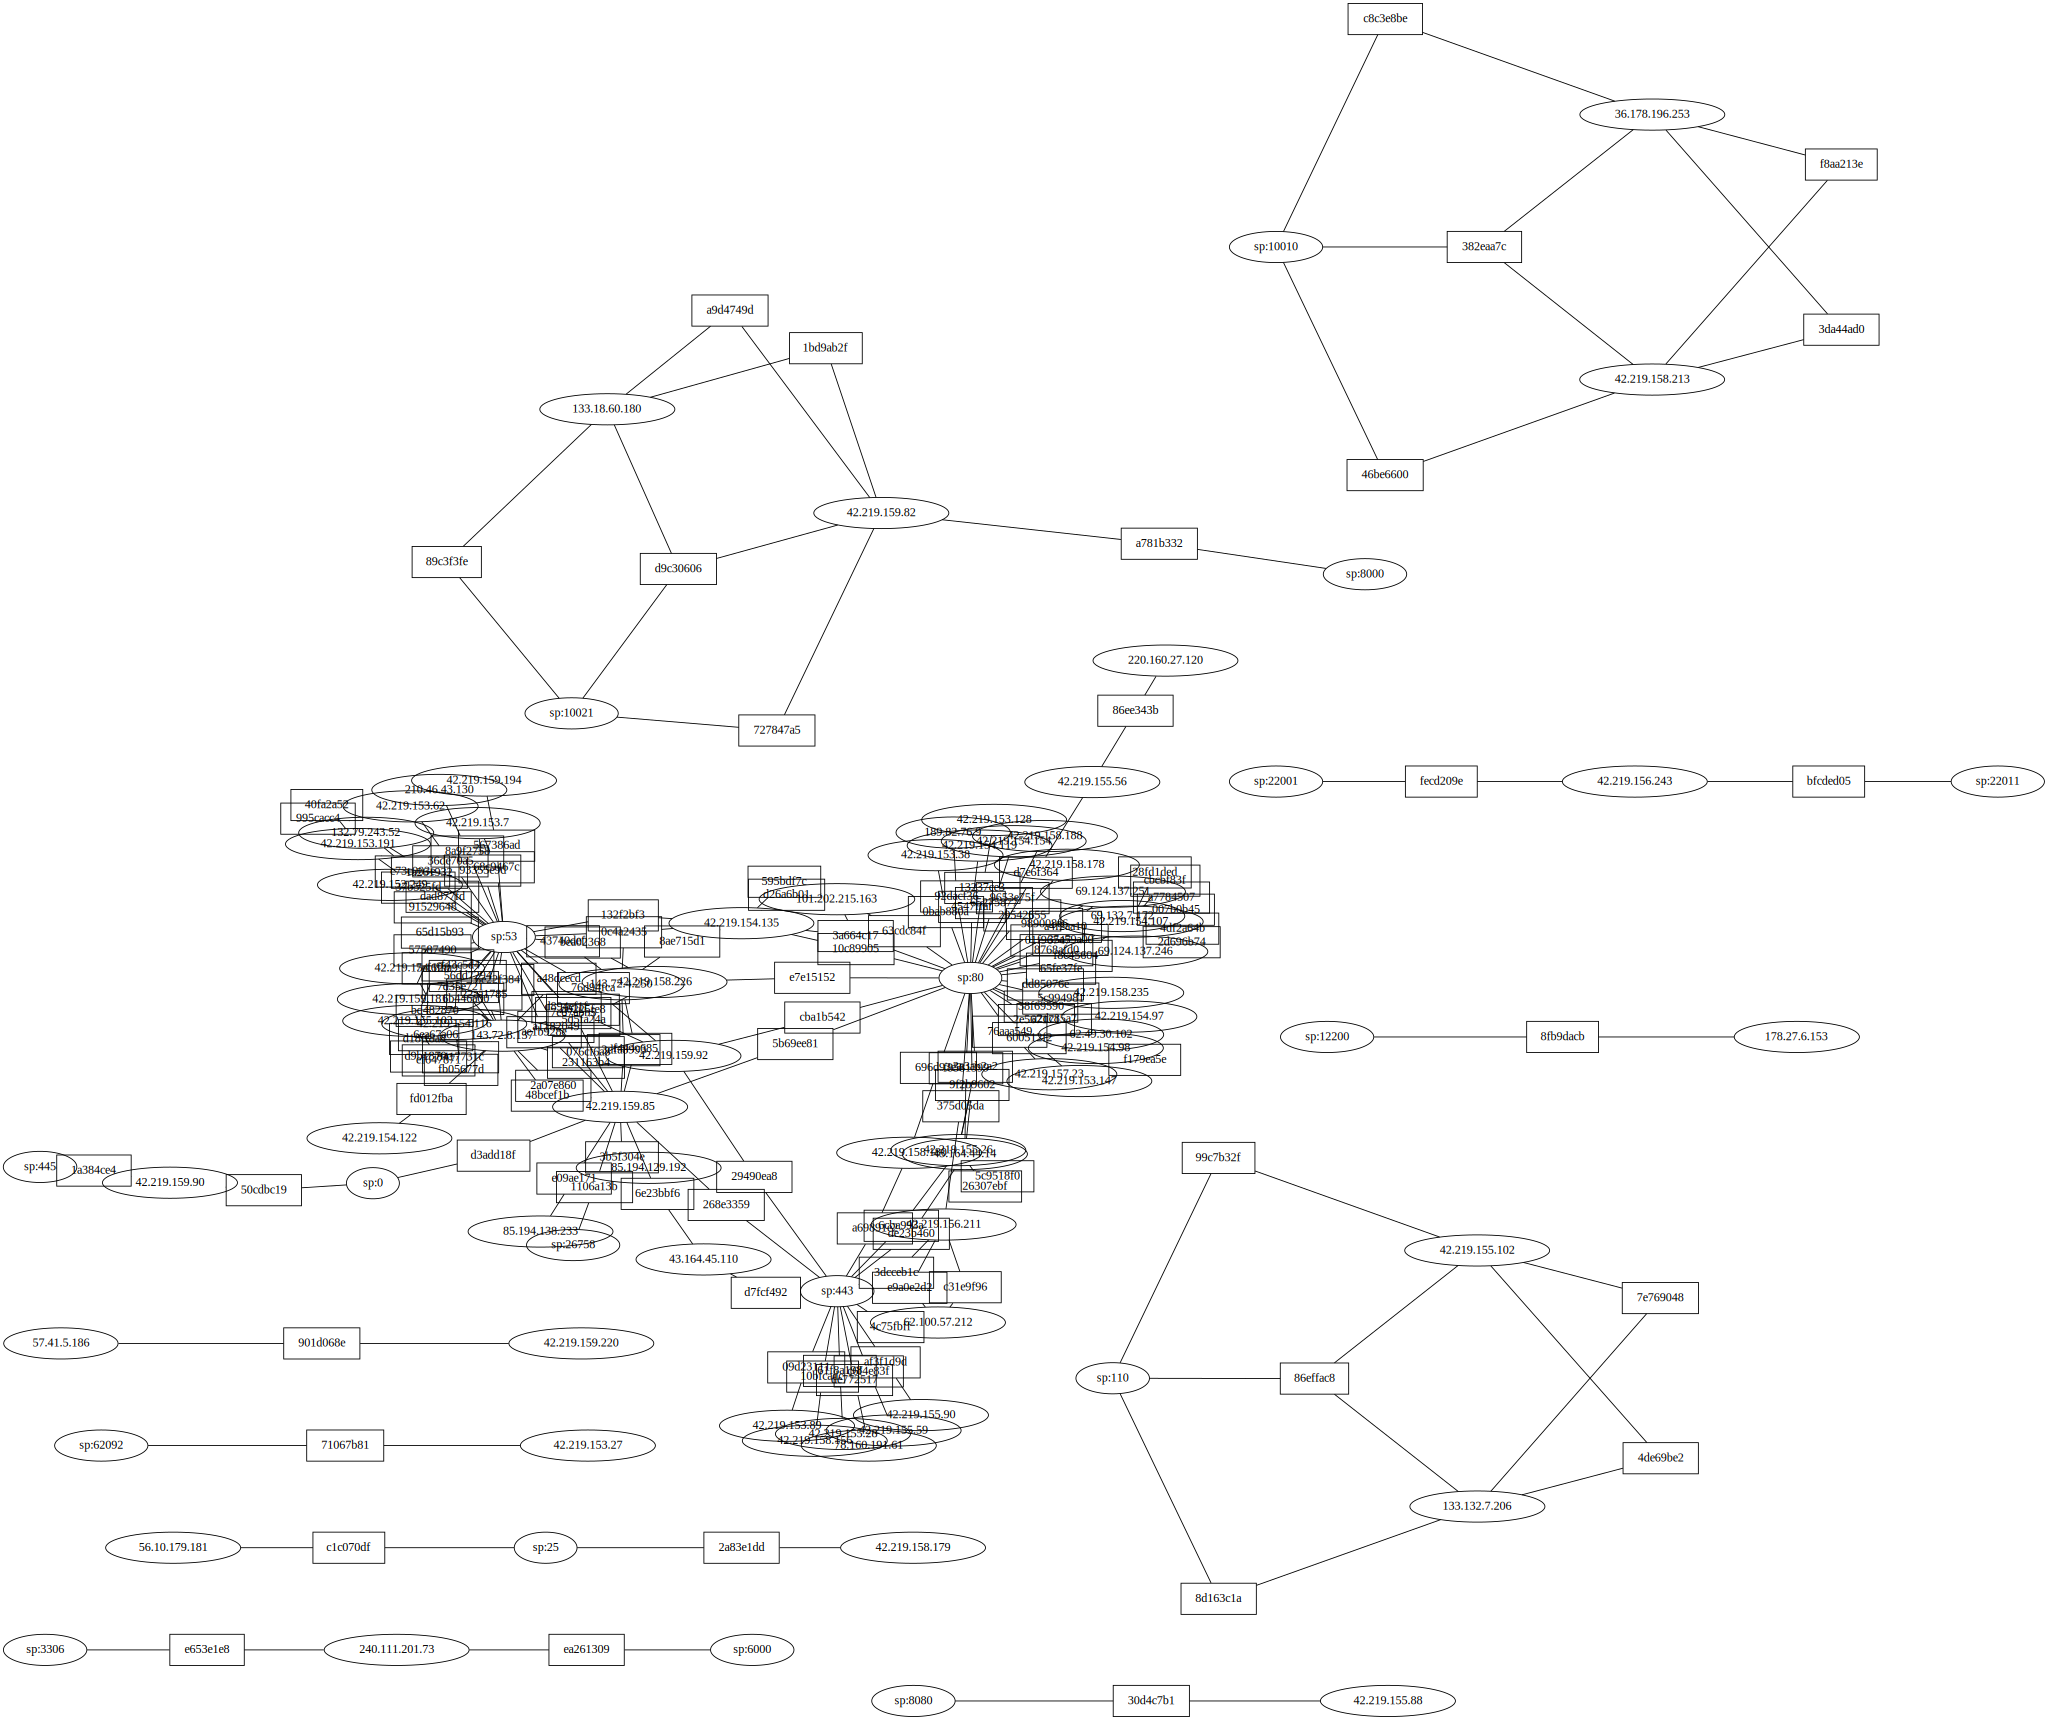

In [116]:
fim1, fim2 = cali_FIS[1], cali_FIS[2]
g1 = unlabeledIPgraphFromSAM(fim1)

In [117]:
# generate graphs for all calibration data
# Create graphs for all timebins
# WARNING: slow operation (RUN ONE ONLY)
# timeLabelAndGraph = [(l, graphFromSAM(FIM(df, minSup))) for l, df in df_attk_groups]
# for time, graph in timeLabelAndGraph:
#     graph.render('2016-07-28/images/'+str(time))
    
# timeLabelAndGraph = [(l, graphFromSAM(FIM(df, minSup))) for l, df in df_cali_groups]
# for time, graph in timeLabelAndGraph:
#     graph.render('2016-06-20/images/'+str(time))

timeLabelAndGraph = [(l, unlabeledIPgraphFromSAM(FIM(df, minSup))) for l, df in df_attk_groups]
for time, graph in timeLabelAndGraph:
    graph.render('2016-07-28/images/ip/'+str(time))
    
timeLabelAndGraph = [(l, unlabeledIPgraphFromSAM(FIM(df, minSup))) for l, df in df_cali_groups]
for time, graph in timeLabelAndGraph:
    graph.render('2016-06-20/images/ip/'+str(time))

In [9]:
def graphFromFIM(samOutput):
    nodes = set()
    itemsets = set()
    edges = {} # (node, itemset) -> support
    
    def hashString(s):
        hash_object = hashlib.sha1(s.encode())
        hex_dig = hash_object.hexdigest()
        return hex_dig

    
    for itemSet in samOutput.keys():
        sup = samOutput[itemSet]
        itemSetStr = hashString(" ".join(list(itemSet)))
        itemsets.add(itemSetStr)

        # add nodes
        for attr in itemSet:
            nodes.add(attr)
            edges[(attr, itemSetStr)] = sup
            
    return (nodes, itemsets, edges)

'''
Edit distance = number of edits required
'''
def editDistance(graph1, graph2):
    dist = 0
    
    g1nodes, g1items, g1edges = graph1
    g2nodes, g2items, g2edges = graph2
    
    dist += len(g1nodes.symmetric_difference(g2nodes))
    dist += len(g1items.symmetric_difference(g2items))
    
    edges1 = set(g1edges.keys())
    edges2 = set(g2edges.keys())
    dist += len(edges1.symmetric_difference(edges2))
    
    return dist
    
'''
Compute edit distance by sum of difference in support (multiplied by cardinality of itemset)
'''
def editDistanceWeighted(graph1, graph2):
    dist = 0
    _nodes, _items, edgeWeights1 = graph1
    _nodes, _items, edgeWeights2 = graph2
    
    for e in edgeWeights1.keys():
        if e not in edgeWeights2:
            dist += minSup + edgeWeights1[e]
        else:
            dist += abs(edgeWeights1[e] - edgeWeights2[e])
    
    for e in edgeWeights2.keys():
        if e not in edgeWeights1:
            dist += minSup + edgeWeights2[e]
        else:
            dist += abs(edgeWeights1[e] - edgeWeights2[e])
    return dist

In [10]:
# run SAM on all groups (WARNING: slow operation)
attk_FIS = [FIM(df, minSup) for _, df in df_attk_groups]
cali_FIS = [FIM(df, minSup) for _, df in df_cali_groups]

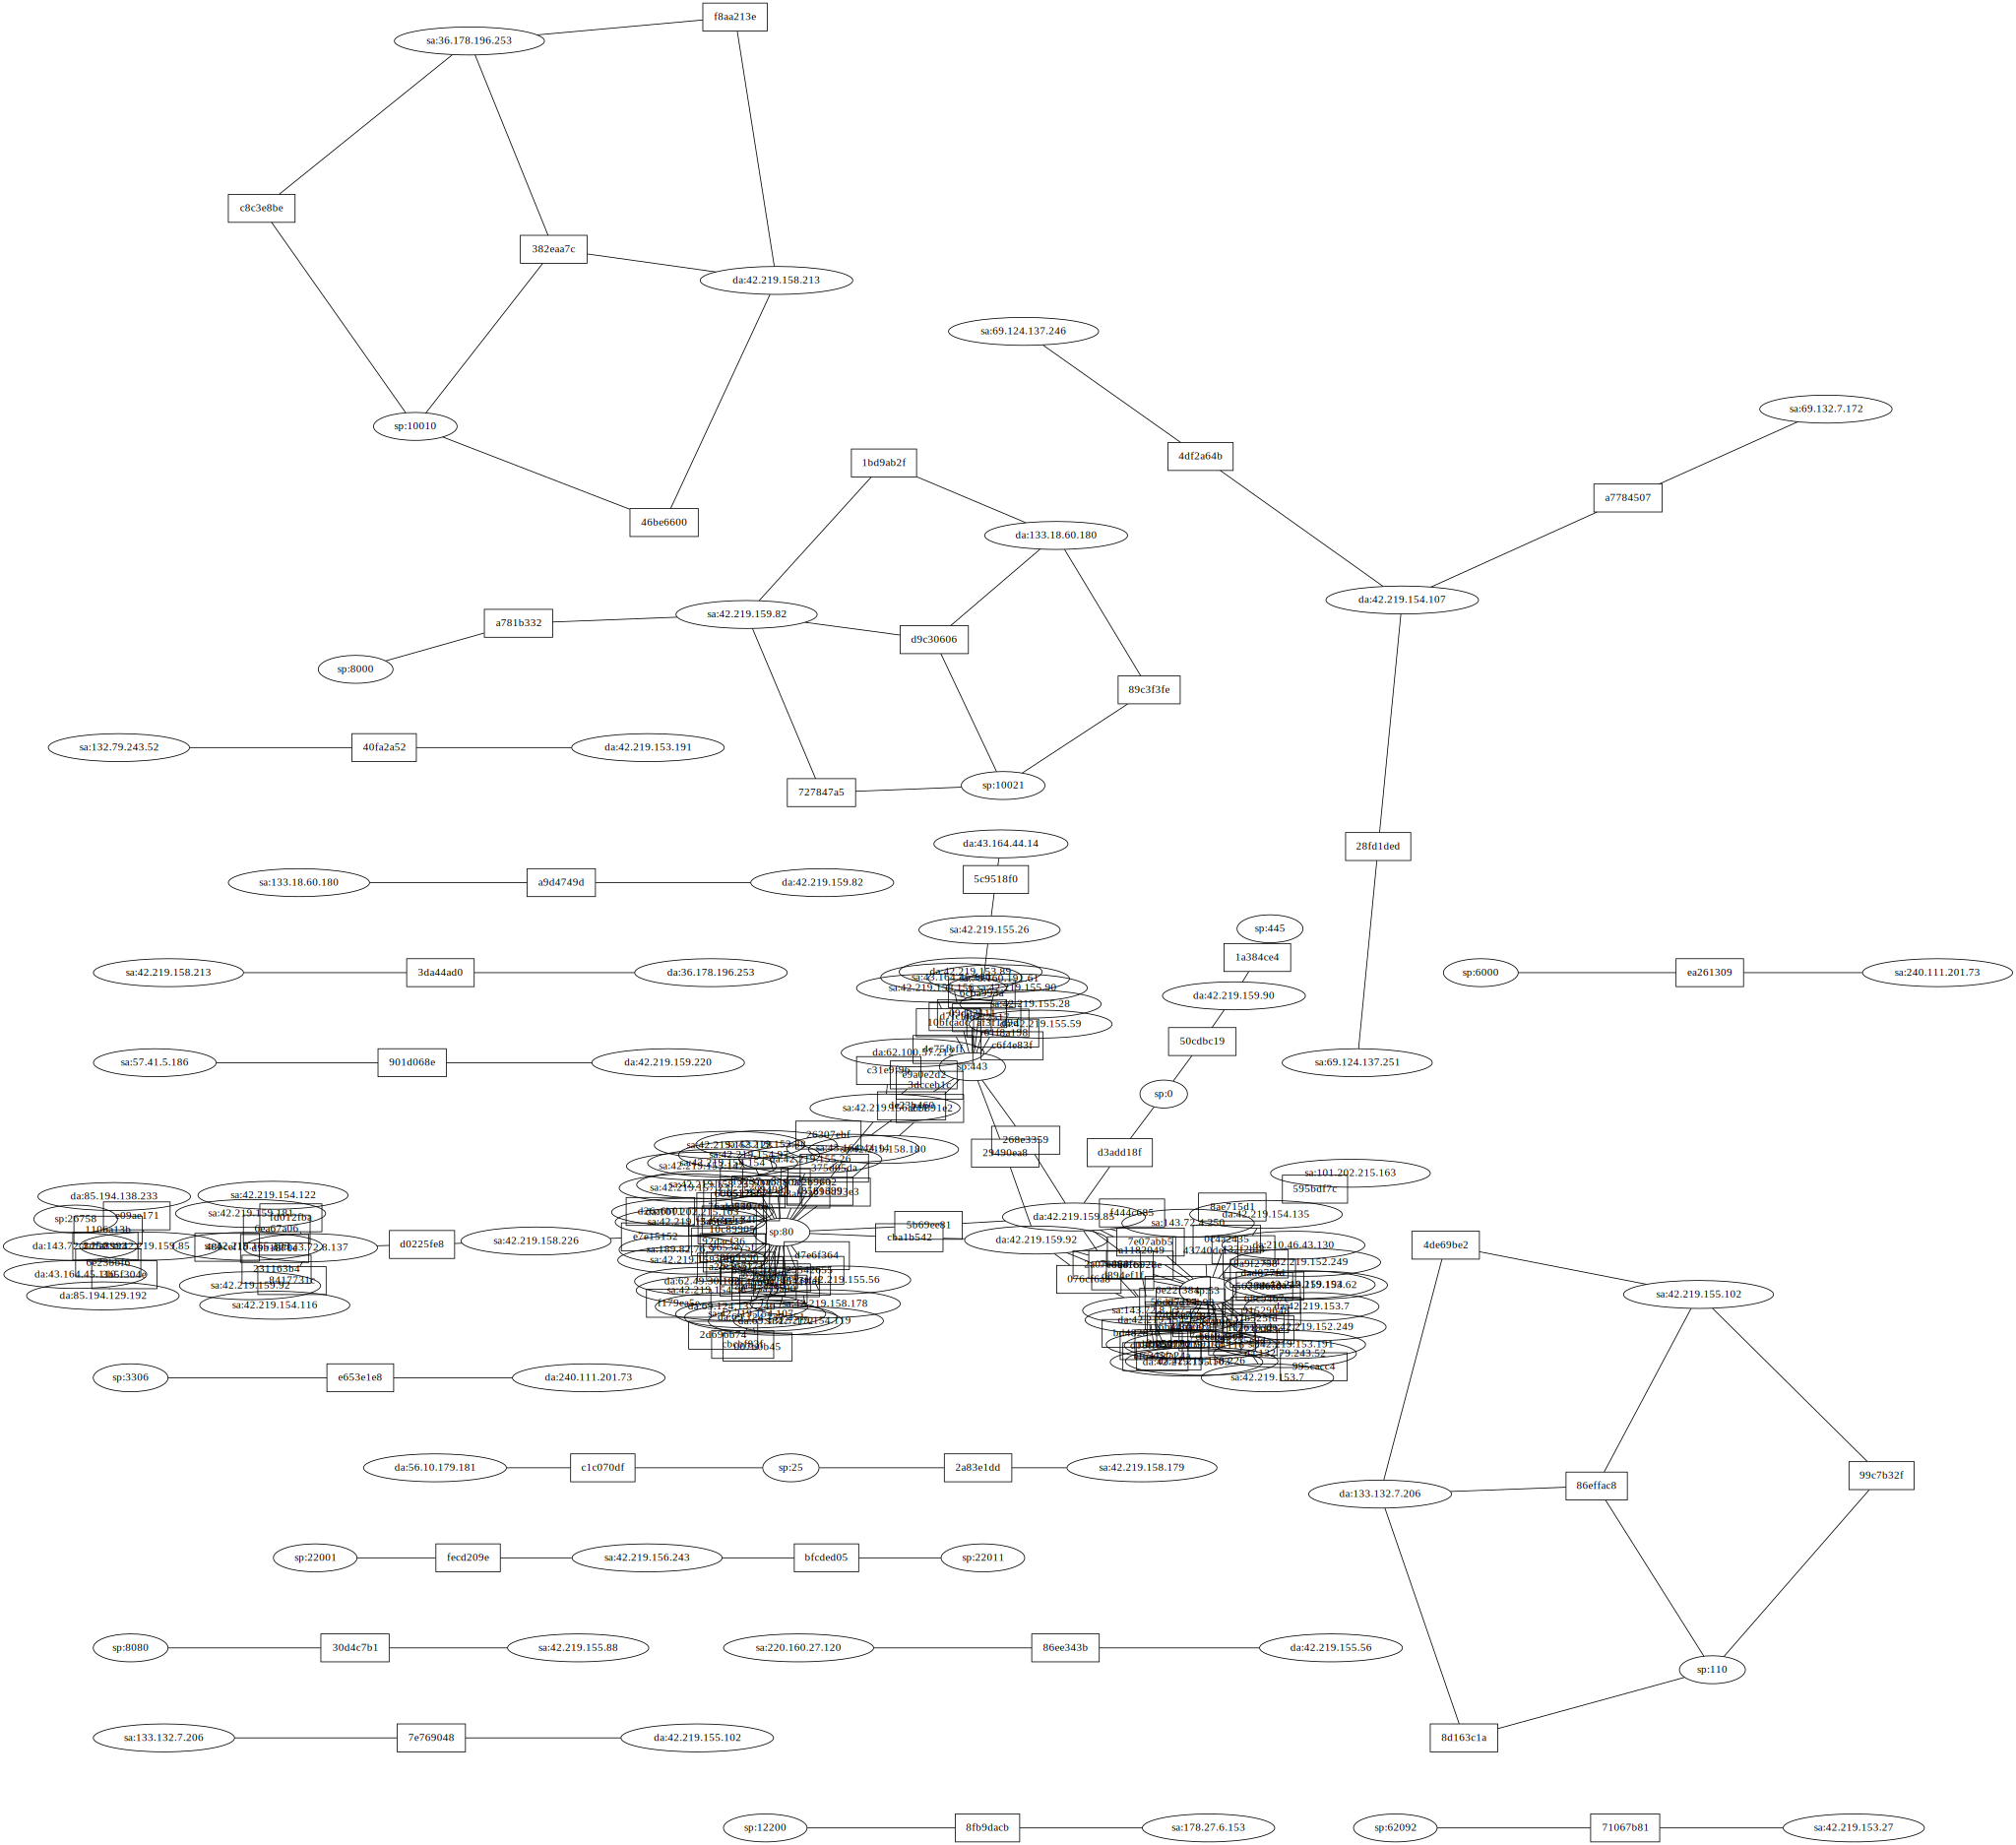

In [56]:
# Debug, edit graph distances are way off
fim1, fim2 = cali_FIS[1], cali_FIS[2]
g1 = graphFromSAM(fim1)
g1

In [11]:
def editDistanceTimeSeries(FIMGroups, editDistance):
    index = [i for i, g in df_groups]
    columns = ['distance']
    data = [0 for i in range(len())]
    
    for currIdx in range(1,len(index)-1):
        prevIdx = currIdx - 1

        currSamOutput = FIMGroups[currIdx]
        prevSamOutput = FIMGroups[prevIdx]    

        gCurr = graphFromFIM(currSamOutput)
        gPrev = graphFromFIM(prevSamOutput)    

        dist = editDistance(gCurr, gPrev)
        data[currIdx] = dist
    
    df_editDistance = pd.DataFrame(data, index = index, columns = columns)
    return df_editDistance

def editDistanceSeries(FIMGroups, editDistance):
    data = [0 for i in range(len(FIMGroups))]
    for currIdx in range(1,len(index)-1):
        prevIdx = currIdx - 1

        currSamOutput = FIMGroups[currIdx]
        prevSamOutput = FIMGroups[prevIdx]    

        gCurr = graphFromFIM(currSamOutput)
        gPrev = graphFromFIM(prevSamOutput)    

        dist = editDistance(gCurr, gPrev)
        data[currIdx] = dist
    
    return data

def editDistanceDualSeries(FIM1, FIM2, editDistance):
    return [editDistance(graphFromFIM(f1), graphFromFIM(f2)) for f1, f2 in zip(FIM1, FIM2)]

In [12]:
# cut off by shorter
attk_FIS = attk_FIS[:min(len(attk_FIS), len(cali_FIS))]
cali_FIS = cali_FIS[:min(len(attk_FIS), len(cali_FIS))]

# graph distance time series
index = [i for i, g in df_attk_groups][1:] # drop the first index
attk_delta = editDistanceSeries(attk_FIS, editDistanceWeighted)
cali_delta = editDistanceSeries(cali_FIS, editDistanceWeighted)

cali_attk_delta = editDistanceDualSeries(attk_FIS, cali_FIS, editDistanceWeighted)

In [35]:
index = [l for l, df in df_cali_groups[:len(attk_FIS)]]

In [36]:
print(index)

[datetime.datetime(2016, 6, 20, 0, 5), datetime.datetime(2016, 6, 20, 0, 10), datetime.datetime(2016, 6, 20, 0, 15), datetime.datetime(2016, 6, 20, 0, 20), datetime.datetime(2016, 6, 20, 0, 25), datetime.datetime(2016, 6, 20, 0, 30), datetime.datetime(2016, 6, 20, 0, 35), datetime.datetime(2016, 6, 20, 0, 40), datetime.datetime(2016, 6, 20, 0, 45), datetime.datetime(2016, 6, 20, 0, 50), datetime.datetime(2016, 6, 20, 0, 55), datetime.datetime(2016, 6, 20, 1, 0), datetime.datetime(2016, 6, 20, 1, 5), datetime.datetime(2016, 6, 20, 1, 10), datetime.datetime(2016, 6, 20, 1, 15), datetime.datetime(2016, 6, 20, 1, 20), datetime.datetime(2016, 6, 20, 1, 25), datetime.datetime(2016, 6, 20, 1, 30), datetime.datetime(2016, 6, 20, 1, 35), datetime.datetime(2016, 6, 20, 1, 40), datetime.datetime(2016, 6, 20, 1, 45), datetime.datetime(2016, 6, 20, 1, 50), datetime.datetime(2016, 6, 20, 1, 55), datetime.datetime(2016, 6, 20, 2, 0), datetime.datetime(2016, 6, 20, 2, 5), datetime.datetime(2016, 6, 20

In [100]:
plt.plot(index, attk_delta)
plt.plot(index, cali_delta)
plt.plot(index, cali_attk_delta)
plt.legend(['july (attack)', 'june (calibration)', 'delta'], loc='upper left')
plt.title('Weighted Distance')
ax = plt.gca()
fmt = '%H:%M'
ax.xaxis.set_major_locator(mdates.HourLocator())
plt.xticks(rotation='vertical')
ax.xaxis.set_major_formatter(mdates.DateFormatter(fmt))

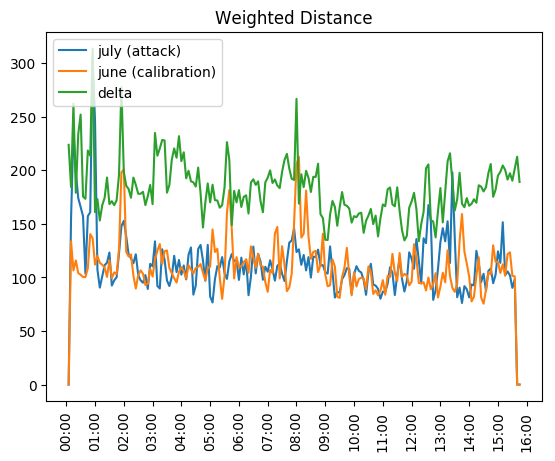

In [101]:
plt.show()

In [29]:
attk_delta_dist = editDistanceSeries(attk_FIS, editDistance)
cali_delta_dist = editDistanceSeries(cali_FIS, editDistance)
cali_attk_delta_dist = editDistanceDualSeries(attk_FIS, cali_FIS, editDistance)

In [49]:
plt.plot(index, attk_delta_dist)
plt.plot(index, cali_delta_dist)
plt.plot(index, cali_attk_delta_dist)
plt.legend(['july (attack)', 'june (calibration)', 'delta'], loc='upper left')
plt.title('Unweighted Distance')

Text(0.5,1,'Unweighted Distance')

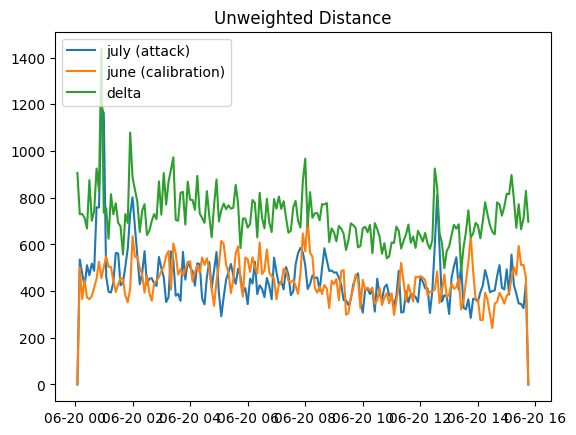

In [50]:
plt.show()

## Investigating Radial Patterns

Two commonly found stars

- da:42.219.156.211
- da:143.72.8.137

E.g at 20/6/16 04:35 

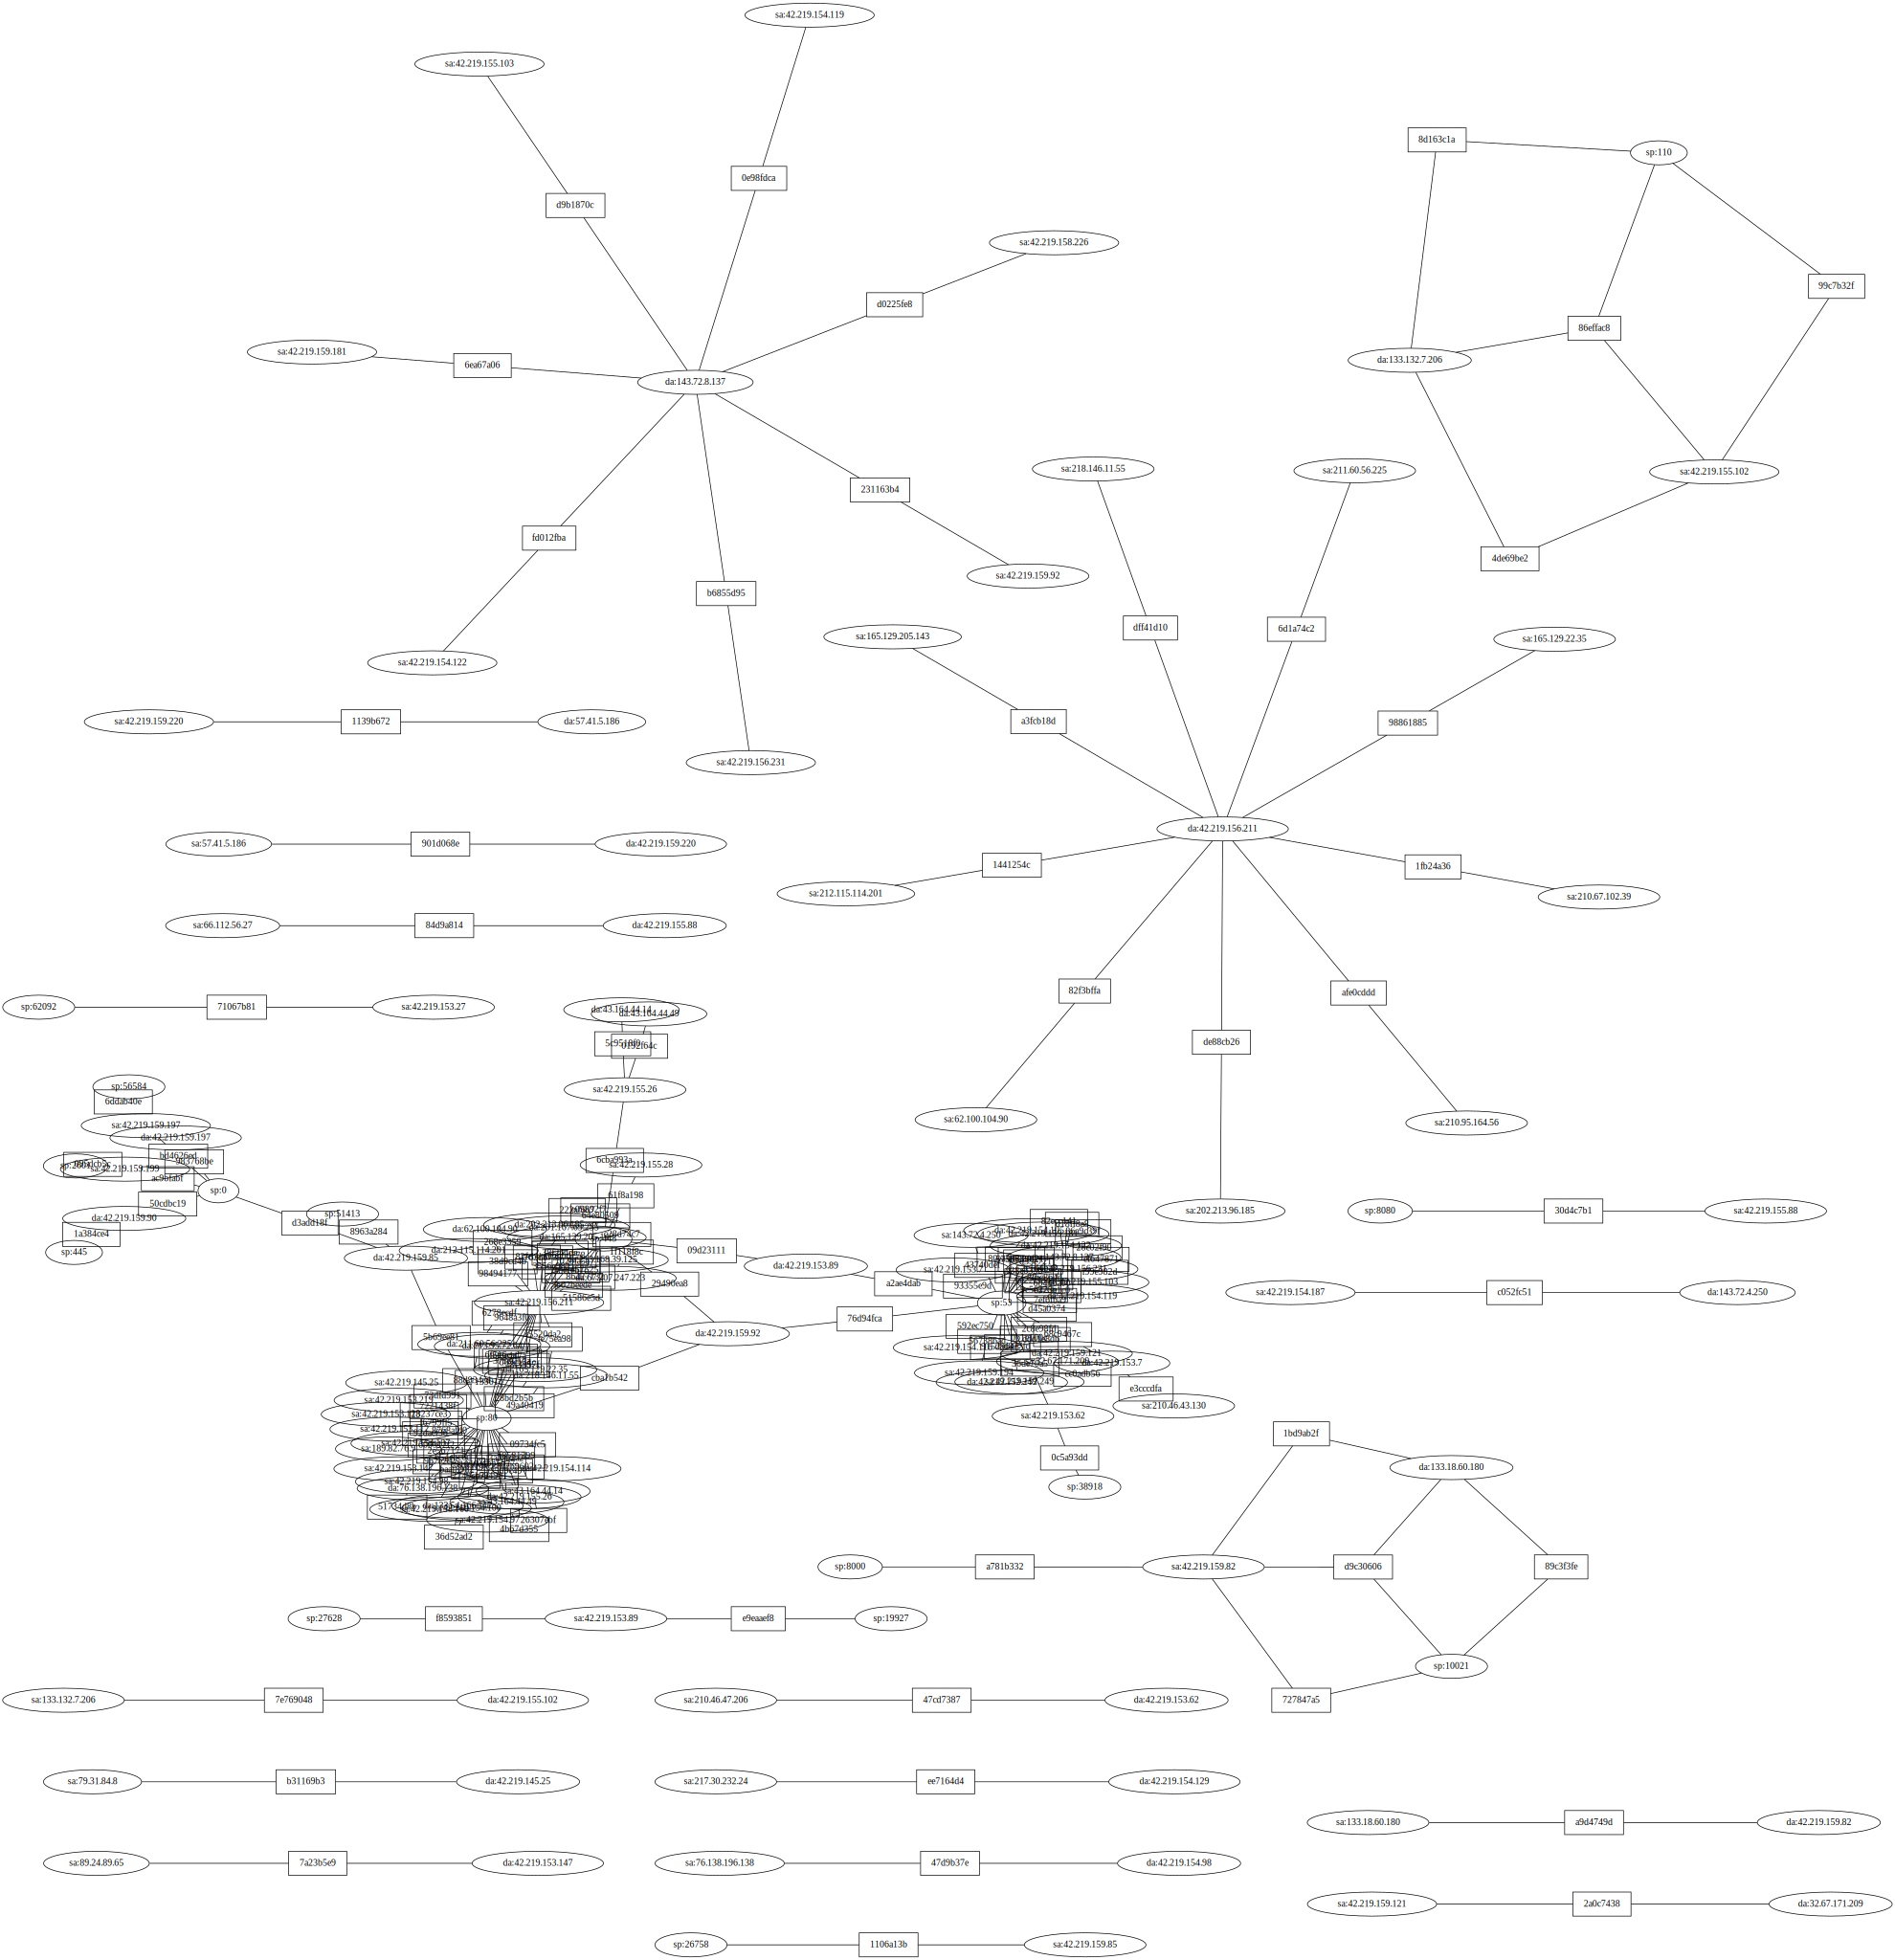

In [60]:
# investigate star patterns
cali_labels = [l for l, df in df_cali_groups]
star_idx = cali_labels.index(datetime.datetime(2016, 6, 20, 4, 35))
g1 = graphFromSAM(cali_FIS[star_idx])
g1

In [83]:
cali_FIS[star_idx]

{('da:133.132.7.206', 'sa:42.219.155.102'): 0.166869,
 ('da:133.132.7.206', 'sa:42.219.155.102', 'sp:110'): 0.166869,
 ('da:133.132.7.206', 'sp:110'): 0.166869,
 ('da:133.18.60.180', 'sa:42.219.159.82'): 0.136529,
 ('da:133.18.60.180', 'sa:42.219.159.82', 'sp:10021'): 0.136529,
 ('da:133.18.60.180', 'sp:10021'): 0.136529,
 ('da:133.54.166.117', 'sa:42.219.154.100'): 0.106189,
 ('da:133.54.166.117', 'sa:42.219.154.100', 'sp:80'): 0.106189,
 ('da:133.54.166.117', 'sp:80'): 0.106189,
 ('da:143.72.4.250', 'sa:42.219.154.187'): 0.136529,
 ('da:143.72.8.137', 'sa:42.219.154.119'): 0.242718,
 ('da:143.72.8.137', 'sa:42.219.154.122'): 0.242718,
 ('da:143.72.8.137', 'sa:42.219.155.103'): 0.106189,
 ('da:143.72.8.137', 'sa:42.219.156.231'): 0.166869,
 ('da:143.72.8.137', 'sa:42.219.158.226'): 0.136529,
 ('da:143.72.8.137', 'sa:42.219.159.181'): 0.106189,
 ('da:143.72.8.137', 'sa:42.219.159.92'): 0.106189,
 ('da:165.129.205.143', 'sa:42.219.156.211'): 0.106189,
 ('da:165.129.205.143', 'sa:42.219.

In [89]:
# see only rows with that dest IP address
starIPs = ['42.219.156.211', '143.72.8.137']

df_star = df_cali_groups[star_idx][1]
df_star[df_star['da'].isin(starIPs)]

,te,td,sa,da,sp,dp,pr,flg,fwd,stos,pkt,byt,type,timebin
394928,2016-06-20 04:35:00,0.000,42.219.154.119,143.72.8.137,53838,53,UDP,.A....,0,0,1,72,background,4887895
394941,2016-06-20 04:35:00,16.004,211.32.60.150,42.219.156.211,60758,443,TCP,.APRS.,0,0,11,1147,background,4887895
394957,2016-06-20 04:35:01,0.324,169.109.54.45,42.219.156.211,55437,80,TCP,.AP.SF,0,0,5,623,background,4887895
394958,2016-06-20 04:35:01,0.352,216.33.72.122,42.219.156.211,47420,80,TCP,.AP.SF,0,0,7,748,background,4887895
394960,2016-06-20 04:35:01,0.444,176.165.248.173,42.219.156.211,35446,443,TCP,.AP.SF,0,0,12,1552,background,4887895
394961,2016-06-20 04:35:01,0.460,214.41.134.24,42.219.156.211,39769,443,TCP,.AP.SF,0,0,12,1552,background,4887895
394962,2016-06-20 04:35:01,0.632,165.130.167.52,42.219.156.211,52804,80,TCP,.AP.SF,0,0,6,700,background,4887895
394977,2016-06-20 04:35:02,0.000,222.239.200.232,42.219.156.211,34087,80,TCP,.A...F,0,0,1,52,background,4887895
394989,2016-06-20 04:35:02,0.208,211.60.56.225,42.219.156.211,62335,80,TCP,.AP.SF,0,0,5,618,background,4887895
394992,2016-06-20 04:35:02,0.244,165.130.167.52,42.219.156.211,53794,80,TCP,.AP.SF,0,0,6,684,background,4887895


In [80]:
df_cali = df_cali[df_cali['da'] == '42.219.136.211']

## 30 minute time bin